# Simulator opinion dynamics

In this notebook we define a simulator of opinon dynamics models.

The specific models of opinion dynamics will be defined by the following functions:
- create_edges: this encodes the interactions between the agents
- opinion_update: this defines how people update their opinions after the interactions
- generate_evidences: this function is not None when the opinions are latent, and we only know some evidences about them

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import coo_array
from torch.distributions.beta import Beta
from torch.distributions.bernoulli import Bernoulli

### Simulator

The simulator_opinion_dynamics method is used to initialize the simulator and to return a trajectory of the opinion dynamics model.

A trajectory is constituted of (i) X, the tensor of all the opinions of the users at each timestep, (ii) edges, the tensor of all the interactions (with sign) at each timestep, (iii) evidences (if not None), the tensor of all the proxies of the opinions for each timestep if the opinions are latent.

In [43]:
class simulator_opinion_dynamics():
    # we define the generic model (such as Bounded Confidence), through the functions create_edges, opinion_update, generate_evidences
    # num_parameters (=3 when the parameters are epsilon, mu rho) and dim_edges (=3 when an edge has the form u,v,s)
    # must be defined here
    def __init__(self, create_edges, opinion_update, generate_evidences = None, num_parameters = 3, dim_edges = 3):
        self.create_edges = create_edges
        self.opinion_update = opinion_update
        self.generate_evidences = generate_evidences
        self.num_parameters = num_parameters
        self.dim_edges = dim_edges
        
    # initialize the simulator with specific parameters, number of agents N, number of timesteps T, 
    # number of edges per timestep edge_per_t, and number of evidences per timestep evidences_per_t
    def initialize_simulator(self, N, T, edge_per_t, evidences_per_t = 0, X0 = [], seed = None):
        self.N = N
        self.T = T
        self.edge_per_t = edge_per_t
        self.evidences_per_t = evidences_per_t
        
        if seed is not None:
            np.random.seed(seed) 
        
        if len(X0) == 0:
            self.X0 = torch.rand(N)
        
    # this returns a trajectory of the opinoin dynamics model defined before with a specific set of parameters
    def simulate_trajectory(self, parameters, seed = None):
        assert len(parameters) == self.num_parameters, f"Required {self.num_parameters} parameters"
        if seed is not None:
            np.random.seed(seed) 
        
        # initialize edges and X
        edges, X = torch.zeros(self.T-1, self.edge_per_t, self.dim_edges), torch.zeros(self.T, self.N)
        X[0] = self.X0
        # store the matrix of the opinion differences diff_X, because opinion_update and create_edges depend on the differences between the opinions
        diff_X = self.X0[:,None] - self.X0[None,:]
        
        if self.evidences_per_t > 0:
            evidences = torch.zeros(self.T, self.evidences_per_t)
        
        # for loop necessary to create the tensors, since the creating and updating functions are complex
        # sto at T-1 because opinions have len T, and edges have len T-1
        for t in range(self.T-1):
            edges[t] = self.create_edges(self.N, self.edge_per_t, diff_X, parameters)
            X[t+1], diff_X = self.opinion_update(diff_X, X[t], edges[t], self.N, parameters)
        trajectory = [X, edges]
        
        if self.evidences_per_t > 0:
            # generate_evidences returns all the proxies of the opinions in one shot 
            evidences = self.generate_evidences(X, self.evidences_per_t, self.T, self.N, parameters)
            trajectory.append(evidences)
        
        return trajectory
    


### Bounded Confidence Model (BCM)
In a bounded confidence model:
- at each step the pairs of users u, v are extracted
- they have a positive interaction if $|X_u-X_v | < \epsilon$. In our case, we consider the stochastic version, where we have a positive interaction with probability $\sigma(\rho \cdot (\epsilon - |X_u-X_v |)) $.
- if the interaction is positive, the two agents get closer each other. The opinions are updated as $X_v^{t+1} = X_v^t + \mu \cdot (X_u^t - X_v^t)$

In [44]:
def create_edges_BC(N, edge_per_t, diff_X, parameters):
    epsilon, mu, rho = parameters
    
    # select edge_per_t pairs random agents (int in [0,N])
    u, v = torch.randint(low = 0, high = N, size = [2, edge_per_t], dtype = torch.long)
    # the sign of the interaction is 0 or 1
    # the probability of having a positive interaction is the sigmoid of epsilon - distance of the opinions
    s = (torch.rand(edge_per_t) < torch.sigmoid(rho * (epsilon - torch.abs(diff_X[u,v])))).to(torch.long)
    
    # return the tensor of len edge_per_t [u,v,s]
    return torch.cat([u[:,None], v[:,None], s[:,None]], dim = 1)
        

def opinion_update_BC(diff_X, X_t, edges_t, N, parameters):
    epsilon, mu, rho = parameters
    u, v, s = edges_t.to(torch.long).T
    s = s.to(torch.float32)
    # store the differences of the opinions in a sparse tensor (coo_array)
    # this is useful to sum the updates for users having more than one interaction per timestep
    # diff_X_uv is 0 for users having negative interaction and X[u] - X[v] for users having positive interactions
    diff_X_uv = coo_array((diff_X[u, v] * s, (u, v)), shape = (N, N))
    # the updates bring the opinions closer each other for users having positive interactions
    updates = mu * (diff_X_uv.sum(axis = 0) - diff_X_uv.sum(axis = 1))
    X_t += updates
    # X is always in [0,1]
    X_t = torch.clamp(X_t, 1e-5, 1-1e-5)
    
    diff_X = X_t[:,None] - X_t[None,:]
    
    return X_t, diff_X


In [45]:
epsilon, mu, rho = parameters = 0.22, 0.4, 70

N, T, edge_per_t = 100, 256, 8


BC_simulator = simulator_opinion_dynamics(create_edges_BC, 
                                          opinion_update_BC, 
                                          num_parameters = 3, 
                                          dim_edges = 3)

In [46]:
BC_simulator.initialize_simulator(N,T,edge_per_t)

In [49]:
X, edges = BC_simulator.simulate_trajectory(parameters, seed = 1203)

In [50]:
X

tensor([[0.7293, 0.8576, 0.3291,  ..., 0.4886, 0.5828, 0.4081],
        [0.7293, 0.8576, 0.3291,  ..., 0.4886, 0.5828, 0.4081],
        [0.7293, 0.8328, 0.3291,  ..., 0.4741, 0.5828, 0.3444],
        ...,
        [0.8079, 0.8096, 0.2766,  ..., 0.2678, 0.2707, 0.2665],
        [0.8079, 0.8096, 0.2766,  ..., 0.2678, 0.2707, 0.2665],
        [0.8079, 0.8096, 0.2766,  ..., 0.2678, 0.2625, 0.2665]])

In [51]:
edges

tensor([[[52., 40.,  0.],
         [29.,  4.,  0.],
         [49., 71.,  0.],
         ...,
         [61., 69.,  0.],
         [28., 16.,  0.],
         [48., 99.,  0.]],

        [[86., 53.,  1.],
         [ 7., 38.,  0.],
         [99., 10.,  1.],
         ...,
         [ 2., 98.,  0.],
         [60., 46.,  0.],
         [96.,  1.,  1.]],

        [[40., 94.,  0.],
         [76., 17.,  0.],
         [29., 58.,  0.],
         ...,
         [26., 13.,  0.],
         [27.,  5.,  1.],
         [91., 45.,  0.]],

        ...,

        [[43., 65.,  1.],
         [90., 41.,  1.],
         [55., 48.,  1.],
         ...,
         [67., 73.,  1.],
         [75., 48.,  0.],
         [25., 41.,  0.]],

        [[86., 72.,  1.],
         [74., 65.,  0.],
         [87., 85.,  1.],
         ...,
         [57., 13.,  1.],
         [18., 27.,  0.],
         [56., 62.,  1.]],

        [[ 4., 44.,  1.],
         [29., 58.,  0.],
         [21., 57.,  0.],
         ...,
         [73., 38.,  1.],
        

In [52]:

#create a plot with all the opinion time trajectories of all users
def print_opinion_trajectory(X, figsize = (5,5)):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(np.matrix(X))
    
    fig.show()


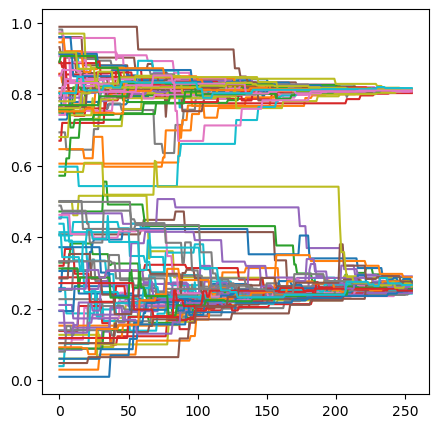

In [53]:
print_opinion_trajectory(X)